In [1]:
# import  the relevant packages and dataset.
!pip install -q torch_snippets
from torch_snippets import *
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2021-08-09 06:47:54.819 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-09 06:47:55.076 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


replace data/faces/testing/s5/1.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [2]:
# define the dataset class SiameseNetworkDataset

class SiameseNetworkDataset(Dataset):
    def __init__(self,folder,transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*')
        self.transform = transform

    def __getitem__(self,ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*',silent= True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
                
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB, np.array([1-same_person])

    def __len__(self):
        return len(self.items) 

In [3]:
# Define the transformation to perform..

from torchvision import transforms
trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5,(0.01,0.2,),scale=(0.9,1.1)),
    
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))

])

trn_ds = SiameseNetworkDataset(folder= "./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

2021-08-09 06:48:09.399 | INFO     | torch_snippets.paths:inner:24 - 370 files found at ./data/faces/training//*/*
2021-08-09 06:48:09.405 | INFO     | torch_snippets.paths:inner:24 - 30 files found at ./data/faces/testing//*/*


In [4]:
# Define the neural network architecture Conv_Block

def convBlock(ni,no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni,no,kernel_size=3,padding=1,padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork,self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )
    
    def forward(self,input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1,output2
        

# Define the contrastive Loss function

In [6]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [7]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [9]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)
    if epoch==10: optimizer = optim.Adam(model.parameters(), lr=0.0005)

EPOCH: 20.000	trn_loss: 0.733	trn_acc: 0.609	val_loss: 0.554	val_acc: 0.733	(20.81s - 187.31s remaining)
EPOCH: 40.000	trn_loss: 0.574	trn_acc: 0.653	val_loss: 0.253	val_acc: 0.833	(42.46s - 169.86s remaining)
EPOCH: 60.000	trn_loss: 0.452	trn_acc: 0.704	val_loss: 0.228	val_acc: 0.967	(63.75s - 148.76s remaining)
EPOCH: 80.000	trn_loss: 0.348	trn_acc: 0.785	val_loss: 0.173	val_acc: 0.867	(85.04s - 127.55s remaining)
EPOCH: 100.000	trn_loss: 0.298	trn_acc: 0.837	val_loss: 0.055	val_acc: 0.967	(105.50s - 105.50s remaining)
EPOCH: 120.000	trn_loss: 0.246	trn_acc: 0.887	val_loss: 0.107	val_acc: 0.867	(126.29s - 84.19s remaining)
EPOCH: 140.000	trn_loss: 0.237	trn_acc: 0.885	val_loss: 0.145	val_acc: 0.867	(147.75s - 63.32s remaining)
EPOCH: 160.000	trn_loss: 0.222	trn_acc: 0.881	val_loss: 0.162	val_acc: 0.867	(168.23s - 42.06s remaining)
EPOCH: 180.000	trn_loss: 0.197	trn_acc: 0.879	val_loss: 0.224	val_acc: 0.767	(188.67s - 20.96s remaining)
EPOCH: 200.000	trn_loss: 0.177	trn_acc: 0.888	val

100%|██████████| 301/301 [00:00<00:00, 3772.42it/s]
2021-08-09 07:13:39.633 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_loss was not fully recorded. Plotting final epochs using last recorded value


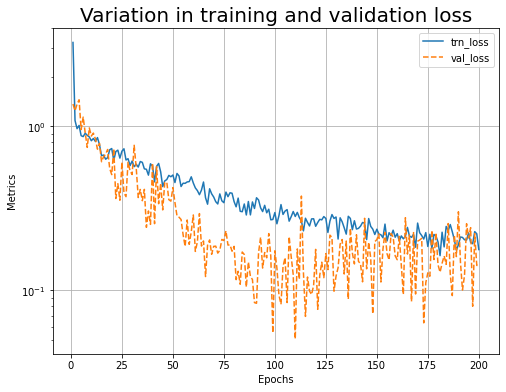

100%|██████████| 301/301 [00:00<00:00, 3755.82it/s]
2021-08-09 07:13:40.148 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_acc was not fully recorded. Plotting final epochs using last recorded value


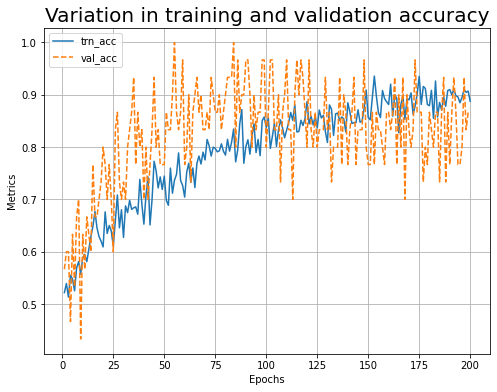

In [10]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


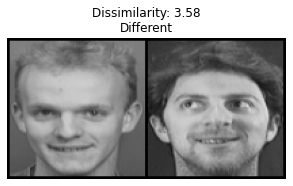

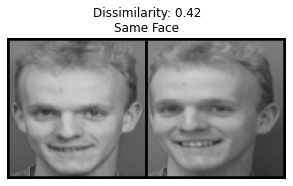

In [11]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()